In [141]:
import codecs, json, glob, os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report, f1_score
import numpy as np
import pandas as pd

from generator import label_mapping
from utils.image_processing import read_resize

from utils.plotting import plot_image_label_prediction, plot_uncertainty_heatmaps, \
    plot_uncertainty_statistics, plot_image, plot_label, plot_predictions, plot_idv_records

result_json_dir = "/home/olle/PycharmProjects/LODE/workspace/feature_segmentation/opt_ensemble2"

configured_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15]



## load json files to evaluate

In [142]:
def read_decode_json(file_path):
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    
    json_result_file = json.loads(obj_text)

    json_result_file["image"] = np.array(json_result_file["image"])
    json_result_file["label"] = np.array(json_result_file["label"])
    json_result_file["prediction"] = np.array(json_result_file["prediction"])
    return json_result_file
    
json_result_paths = glob.glob(result_json_dir + "/*.json")

result_jsons = {}
for json_file_path in json_result_paths:
    record = json_file_path.split("/")[-1].replace(".json", "")
    result_jsons[record] = read_decode_json(json_file_path)

## plot records for publication

In [143]:
records = result_jsons.keys()

for record in records:
    record_log = result_jsons[record]
    data = [record_log["image"], record_log["label"], record_log["prediction"]]
    
    # all plotting functions
    plot_image_label_prediction(data,model_dir = result_json_dir, filename=record, mode="test")
    plot_image(record_log["image"], model_dir = result_json_dir, filename=record, mode="test")
    plot_label(record_log["label"], model_dir = result_json_dir, filename=record, mode="test")
    plot_predictions([record_log["prediction"]], model_dir = result_json_dir, filename=record, mode="test")

## create results per record result logs

In [144]:
records = result_jsons.keys()

f1_record_log = {}
f1_total_log = {}

all_labels = []
all_predictions = []

for record in records:
    record_log = result_jsons[record]
    
    labels = record_log["label"].flatten()
    predictions = record_log["prediction"].flatten()
    
    all_labels.extend(labels.tolist())
    all_predictions.extend(predictions.tolist())
    
    f1_record_log[record] = f1_score(labels, 
                         predictions, 
                         average = None, 
                         labels = configured_labels, 
                         zero_division=1)

# calculate for each log
f1_total_log = f1_score(all_labels, 
                        all_predictions, 
                        average = None, 
                        labels = configured_labels, 
                        zero_division=1)

# convert to data frames for plotting
total_f1_pd = pd.DataFrame(f1_total_log).T.replace(1.0,np.NaN)
record_f1_pd = pd.DataFrame(f1_record_log).T.replace(1.0,np.NaN)

In [146]:
total_f1_pd.T

,0
0,0.982403
1,0.583168
2,0.980108
3,0.766243
4,0.976910
5,0.538299
6,0.837713
7,0.779026
8,0.634337
9,0.758062


## Inter doctor variation analysis

In [70]:
# set env variables
idv_json_dir = "/home/olle/PycharmProjects/LODE/workspace/feature_segmentation/opt_ensemble2/idv"
evaluators = ["ben", "johannes", "michael", "concensus"]

In [71]:
def read_decode_json(file_path):
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    
    json_result_file = json.loads(obj_text)
    json_result_file["image"] = np.array(json_result_file["image"])
    
    # add all evaluators results
    for evaluator in evaluators:
        json_result_file[f"{evaluator}_mask"] = np.array(json_result_file[f"{evaluator}_mask"])

    json_result_file["prediction"] = np.array(json_result_file["prediction"])
    return json_result_file
    
json_result_paths = glob.glob(idv_json_dir + "/*.json")

result_jsons = {}
for json_file_path in json_result_paths:
    record = json_file_path.split("/")[-1].replace(".json", "")
    result_jsons[record] = read_decode_json(json_file_path)

## plot all records

In [72]:
records = result_jsons.keys()

for record in records:
    record_log = result_jsons[record]
    data = [record_log["image"], record_log["concensus_mask"], record_log["prediction"]]
    
    # all plotting functions
    plot_image_label_prediction(data,model_dir = idv_json_dir, filename=record, mode="test")
    plot_image(record_log["image"], model_dir = idv_json_dir, filename=record, mode="test")
    
    records_idv = []
    records_idv.append(record_log["image"])
    records_idv.append(record_log["concensus_mask"])
    
     # add all evaluators results
    for evaluator in evaluators:
        plot_label(record_log[f"{evaluator}_mask"], 
                   model_dir = idv_json_dir, 
                   filename=f"{evaluator}_{record}", 
                   mode="test")
        
    
    for name in ["ben", "johannes", "michael"]:
        records_idv.append(record_log[f"{name}_mask"])

    
    records_idv.append(record_log["prediction"])

    plot_predictions([record_log["prediction"]], model_dir = idv_json_dir, filename=record, mode="test")
    
    
    plot_idv_records(records_idv, model_dir=idv_json_dir, mode="test_idv", filename=record)

## extract results

In [80]:
records = result_jsons.keys()

f1_record_log = {}
f1_total_log = {}

labels_predictions = {"concensus": []}

for evaluator in evaluators + ["prediction"]:
    labels_predictions[evaluator] = []
        
for record in records:
    record_log = result_jsons[record]
    
    labels_predictions["prediction"].extend(record_log[f"prediction"].flatten().tolist())

    for evaluator in evaluators:
        labels_predictions[evaluator].extend(record_log[f"{evaluator}_mask"].flatten().tolist())


In [81]:
idv_logs = {}
for evaluator in evaluators + ["prediction"]:
    # calculate for each log
    f1_total_log = f1_score(labels_predictions["concensus"], 
                            labels_predictions[evaluator], 
                            average = None, 
                            labels = configured_labels, 
                            zero_division=1)

    idv_logs[evaluator] = f1_total_log
    
# convert to data frames for plotting
total_f1_pd = pd.DataFrame(idv_logs).T.replace(1.0,np.NaN)


,index,ben,johannes,michael,concensus,prediction
0,0,0.987462,0.981271,0.980077,1.0,0.976575
1,1,0.668525,0.723929,0.775066,1.0,0.574681
2,2,0.981550,0.984672,0.978594,1.0,0.969124
3,3,0.782723,0.544320,0.662546,1.0,0.300699
4,4,0.901279,0.979641,0.904317,1.0,0.846916
5,5,0.833611,0.777933,0.794467,1.0,0.612030
6,6,0.843795,0.820144,0.815021,1.0,0.742423
7,7,0.753525,0.793027,0.747310,1.0,0.625887
8,8,0.627262,0.686775,0.635426,1.0,0.614000
9,9,0.841681,0.804777,0.789059,1.0,0.632891


,index,variable,value
0,0,ben,0.987462
1,1,ben,0.668525
2,2,ben,0.981550
3,3,ben,0.782723
4,4,ben,0.901279
...,...,...,...
65,9,prediction,0.632891
66,10,prediction,0.833652
67,11,prediction,0.726384
68,12,prediction,0.993373


In [119]:
idv_pd = pd.DataFrame(idv_logs)
idv_pd = idv_pd.reset_index()

idv_pd_long = pd.melt(idv_pd, id_vars="index")

idv_pd_long = idv_pd_long[~idv_pd_long.variable.isin(["concensus"])]

idv_pd_long = idv_pd_long.rename(columns={"variable":"annotator", "value":"f1-score", "index":"class"})

idv_pd_long = idv_pd_long[idv_pd_long["class"].isin(["5", "7", "8", "11"])]


In [139]:
idv_pd_long.loc[:, "annotator"] = idv_pd_long.annotator.replace({"ben": "annotator I", 
                                                                 "johannes": "annotator II", 
                                                                 "michael": "annotator III"})

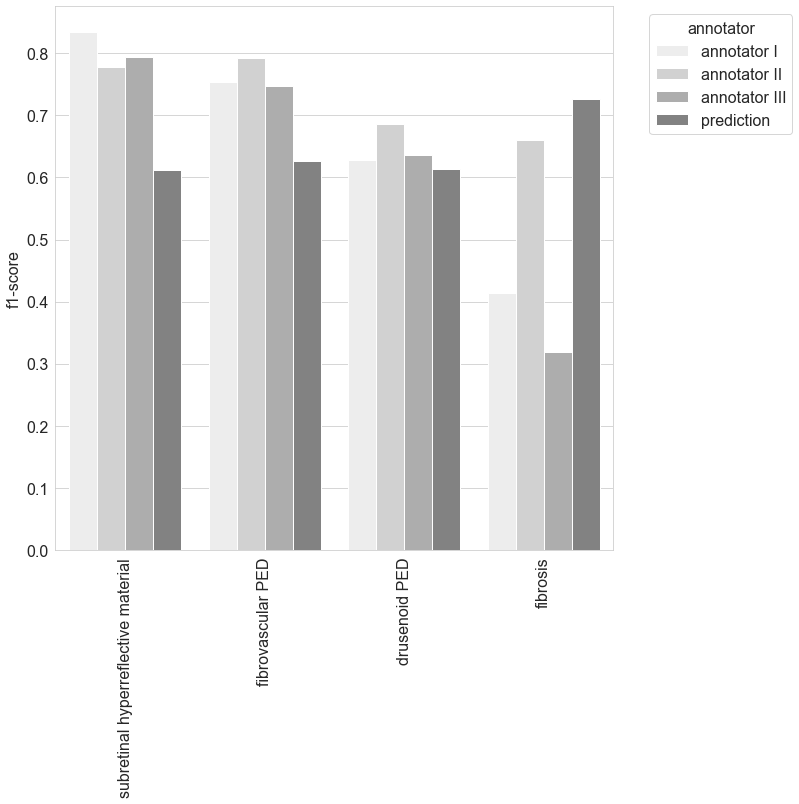

In [140]:

class_dict = {0:"background", 1:"epiretinal membrane", 2:"neurosensory retina", 
              3:"intraretinal fluid", 4:"subretinal fluid", 5:"subretinal hyperreflective material", 
              6:"RPE", 7:"fibrovascular PED", 8:"drusenoid PED", 9: "posterior hyaloid membrance", 
              10:"choroid", 11:"fibrosis", 14:"vitreous", 15:"camera effect"}

sns.set_palette("Greys")
ax = sns.barplot(x="class", y="f1-score", hue="annotator", data=idv_pd_long)
plt.xticks(ticks=[0,1,2,3], labels=[class_dict[5], class_dict[7], class_dict[8], class_dict[11]],
          rotation = 90)

plt.xlabel("")

plt.legend(title='annotator', bbox_to_anchor=(1.05, 1), loc='upper left')
